In [2]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# 使用SMOTE处理训练数据不平衡问题
from imblearn.over_sampling import SMOTE
import os
# Set plot style for nicer visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [3]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X_df = bank_marketing.data.features
y_df = bank_marketing.data.targets
df = pd.concat([X_df, y_df], axis=1)
# Display metadata and variable information (as you provided)
print("--- Dataset Metadata ---")
print(bank_marketing.metadata)
print("\n--- Variable Information ---")
print(bank_marketing.variables)

--- Dataset Metadata ---
{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven 

In [4]:
# 3. Initial Data Exploration

df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [5]:
# Target variable: 'y' - has the client subscribed a term deposit? (binary: "yes","no")
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [6]:
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


处理缺失值

缺失值都出现在类别变量里，在这类变量里unkown也保留一定信息，同时符合数据定义

In [7]:

print("--- 原始缺失值统计 ---")
print(df.isnull().sum())

# 需要处理缺失值的列
columns_with_nan = ['job', 'education', 'contact', 'poutcome']

# 对于这些特定的类别列，将 NaN 填充为 "unknown"
for col in columns_with_nan:
    if df[col].isnull().any(): # 检查该列是否确实存在缺失值
        print(f"正在将列 '{col}' 中的 NaN 填充为 'unknown'...")
        df[col] = df[col].fillna("unknown")

print("\n--- 处理后缺失值统计 ---")
print(df.isnull().sum())

--- 原始缺失值统计 ---
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64
正在将列 'job' 中的 NaN 填充为 'unknown'...
正在将列 'education' 中的 NaN 填充为 'unknown'...
正在将列 'contact' 中的 NaN 填充为 'unknown'...
正在将列 'poutcome' 中的 NaN 填充为 'unknown'...

--- 处理后缺失值统计 ---
age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64


In [8]:
#创建符号变量，没联系过是0，联系过是1
df['pdays_was_contacted'] = (df['pdays'] != -1).astype(int)
df['pdays_was_contacted'] = df['pdays_was_contacted'].astype('category')
df['pdays_log1p'] = df['pdays'].copy() # 先复制
df.loc[df['pdays_log1p'] == -1, 'pdays_log1p'] = 0 # 将-1映射到0，因为log1p(0)=0
df['pdays_log1p'] = np.log1p(df['pdays_log1p'])

# 1. 创建 'balance_sign' 特征
df['balance_sign'] = np.sign(df['balance'])
# 可以进一步映射为类别: {-1: 'negative', 0: 'zero', 1: 'positive'}
df['balance_sign_category'] = df['balance_sign'].map({-1: 'negative', 0: 'zero', 1: 'positive'}).astype('category')
print("\n创建 'balance_sign' 和 'balance_sign_category' 特征:")
print(df[['balance', 'balance_sign', 'balance_sign_category']].head())

# 2. 对 'balance' 的绝对值进行 log1p 变换
df['balance_log_abs_p1'] = np.log1p(np.abs(df['balance']))


创建 'balance_sign' 和 'balance_sign_category' 特征:
   balance  balance_sign balance_sign_category
0     2143             1              positive
1       29             1              positive
2        2             1              positive
3     1506             1              positive
4        1             1              positive


In [9]:
selected_features_for_X=[ 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'day_of_week', 'month', 'duration', 'campaign', 'previous',
    'poutcome', 'pdays_was_contacted', 'pdays_log1p',
     'balance_sign_category', 'balance_log_abs_p1']

df = df[selected_features_for_X + ['y']]
df.head(5)

,age,job,marital,education,default,housing,loan,contact,day_of_week,month,duration,campaign,previous,poutcome,pdays_was_contacted,pdays_log1p,balance_sign_category,balance_log_abs_p1,y
0,58,management,married,tertiary,no,yes,no,unknown,5,may,261,1,0,unknown,0,0.0,positive,7.670429,0
1,44,technician,single,secondary,no,yes,no,unknown,5,may,151,1,0,unknown,0,0.0,positive,3.401197,0
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,5,may,76,1,0,unknown,0,0.0,positive,1.098612,0
3,47,blue-collar,married,unknown,no,yes,no,unknown,5,may,92,1,0,unknown,0,0.0,positive,7.317876,0
4,33,unknown,single,unknown,no,no,no,unknown,5,may,198,1,0,unknown,0,0.0,positive,0.693147,0


In [10]:
# 识别类别特征和数值特征
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('y') # 从数值特征中移除目标变量
print("类别特征：", categorical_features
      ,"\n数值特征：", numerical_features)

类别特征： ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_was_contacted', 'balance_sign_category'] 
数值特征： ['age', 'day_of_week', 'duration', 'campaign', 'previous', 'pdays_log1p', 'balance_log_abs_p1']


创建pipeline减少重复操作

In [11]:
# 为数值和类别特征创建预处理管道
numerical_transformer = StandardScaler() # 数值特征标准化
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first') # 类别特征独热编码, drop='first' 避免多重共线性
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features), # 数值转换器
        ('cat', categorical_transformer, categorical_features) # 类别转换器
    ])

In [12]:
# 在预处理目标变量后再次分离特征 (X) 和目标 (y)
X = df.drop('y', axis=1)
y = df['y']

开始划分训练测试集并尝试不同方法

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # stratify=y 确保类别比例一致
print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}") # 打印训练集和测试集形状
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (33908, 18), X_test shape: (11303, 18)
y_train shape: (33908,), y_test shape: (11303,)


In [14]:
models = {
    #TODO：可以调整逻辑回归的solver以及正则化参数，SVM的kernel等
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42), # 逻辑回归
    "Decision Tree": DecisionTreeClassifier(random_state=42), # 决策树
    "Random Forest": RandomForestClassifier(random_state=42), # 随机森林
     "Support Vector Machine (RBF Kernel)": SVC(kernel='rbf', gamma='scale', probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),# 朴素贝叶斯 (作为另一种统计/概率方法添加)
      "LightGBM": lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        n_jobs=-1,
        # class_weight='balanced'  # 处理类别不平衡
    ),
    "CatBoost": CatBoostClassifier(
    iterations=300,                  # 增加迭代次数以获得更好的收敛
    learning_rate=0.05,              # 降低学习率以更好地泛化
    depth=8,                         # 增加树深度以捕捉更复杂的模式
    loss_function='Logloss',
    l2_leaf_reg=3,                   # L2正则化参数，防止过拟合
    random_seed=42,
    eval_metric='AUC',               # 使用AUC作为评估指标，适合不平衡数据
    leaf_estimation_method='Newton', # 使用牛顿法可能获得更好的收敛
    verbose=0,                       # 减少输出信息
    
    # 提高训练效率的参数
    thread_count=-1,                 # 使用所有可用CPU核心
    task_type='CPU',                 # 可根据环境改为'GPU'
    
    # 避免过拟合的参数
    bootstrap_type='Bayesian',       # 贝叶斯自举采样
    bagging_temperature=1,           # 控制贝叶斯采样的随机性强度
    
    # 特征重要性和交互
    max_ctr_complexity=2,            # 允许更复杂的类别特征组合
    grow_policy='Lossguide',         # 基于损失改进构建树
    min_data_in_leaf=10,             # 每个叶节点的最小样本数
    max_leaves=64                    # 树的最大叶子数
),
 "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=2,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=-1,
        seed=42,
        tree_method='hist'  # 更快的训练速度
    )
}



In [15]:
# 为了CatBoost正确处理类别特征，我们需要识别它们的索引
categorical_indices = []
for i, column in enumerate(X_train.columns):
    if column in categorical_features:
        categorical_indices.append(i)

In [16]:
results = {} # 存储评估结果
classification_reports = {} # 存储分类报告
confusion_matrices = {} # 存储混淆矩阵

In [17]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

def g_mean_score(y_true, y_pred):
    """
    计算几何平均精度(G-mean): G-mean = √(Recall × Specificity)
    
    参数:
        y_true: 真实标签
        y_pred: 预测标签
        
    返回:
        g_mean: G-mean得分
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # 召回率/敏感性
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 特异性
    
    g_mean = np.sqrt(recall * specificity)
    return g_mean

def plot_pr_curve(y_true, y_prob, model_name):
    """
    绘制精确率-召回率曲线(PR曲线)并计算曲线下面积(AUPRC)
    
    参数:
        y_true: 真实标签
        y_prob: 预测概率
        model_name: 模型名称
    
    返回:
        auprc: PR曲线下面积
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AUPRC = {auprc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # 添加随机分类器的基准线
    no_skill = np.sum(y_true) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], '--', color='gray', label=f'No Skill (AUPRC = {no_skill:.4f})')
    plt.legend(loc='best')
    
    plt.show()
    
    return auprc


--- Training and Evaluating: Logistic Regression ---


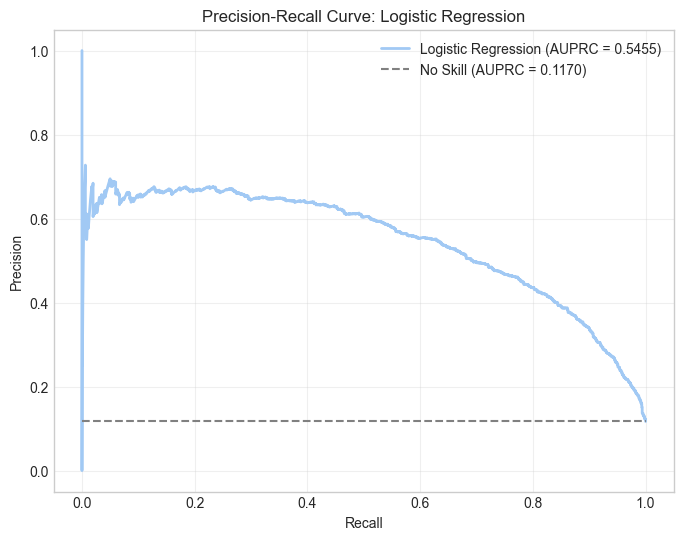

Accuracy: 0.9019
Precision: 0.6485
Recall: 0.3517
F1-score: 0.4561
G-mean: 0.5855
ROC AUC: 0.9061

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9981
           1       0.65      0.35      0.46      1322

    accuracy                           0.90     11303
   macro avg       0.78      0.66      0.70     11303
weighted avg       0.89      0.90      0.89     11303



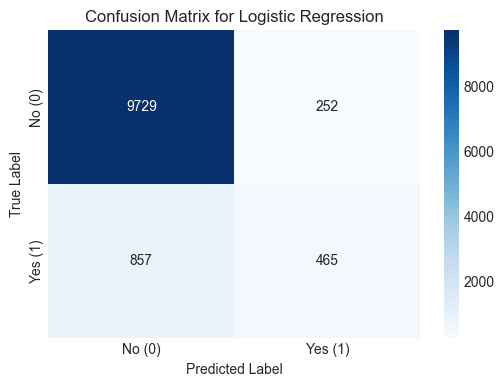


--- Training and Evaluating: Decision Tree ---


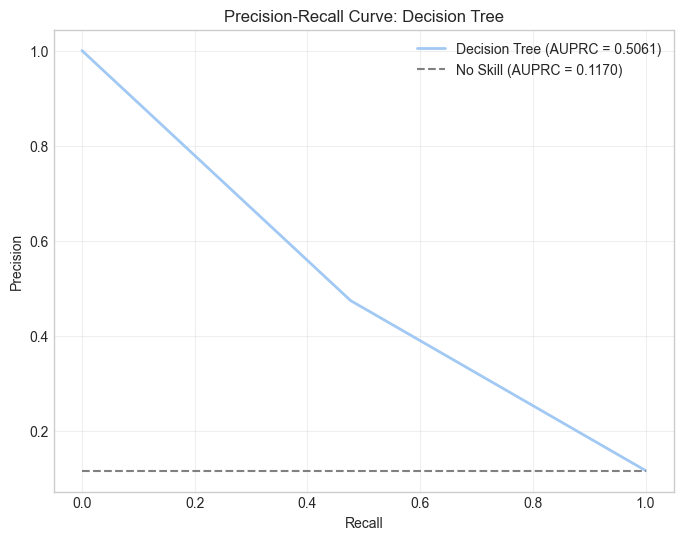

Accuracy: 0.8770
Precision: 0.4744
Recall: 0.4766
F1-score: 0.4755
G-mean: 0.6658
ROC AUC: 0.7033

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      9981
           1       0.47      0.48      0.48      1322

    accuracy                           0.88     11303
   macro avg       0.70      0.70      0.70     11303
weighted avg       0.88      0.88      0.88     11303



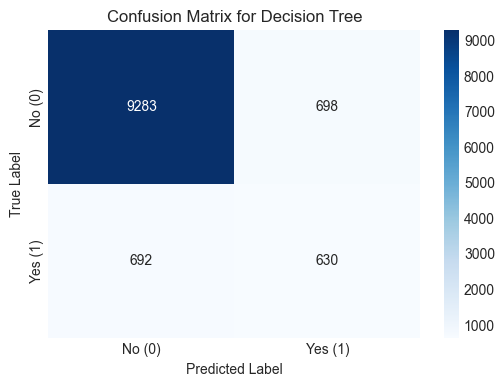


--- Training and Evaluating: Random Forest ---


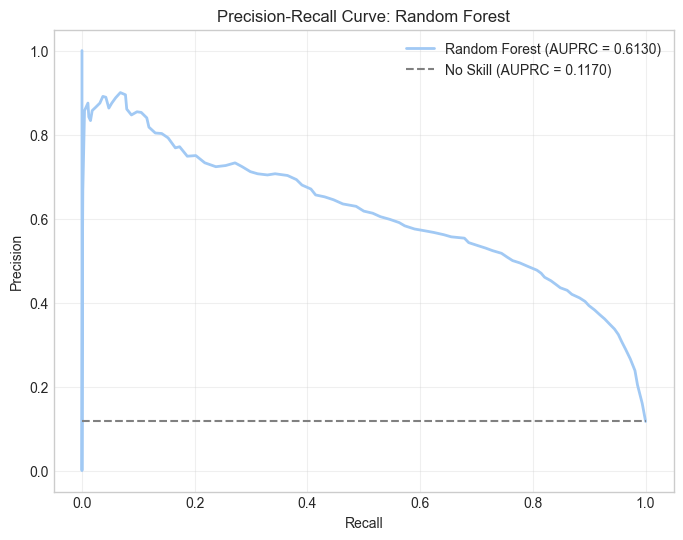

Accuracy: 0.9072
Precision: 0.6798
Recall: 0.3903
F1-score: 0.4959
G-mean: 0.6171
ROC AUC: 0.9236

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9981
           1       0.68      0.39      0.50      1322

    accuracy                           0.91     11303
   macro avg       0.80      0.68      0.72     11303
weighted avg       0.90      0.91      0.90     11303



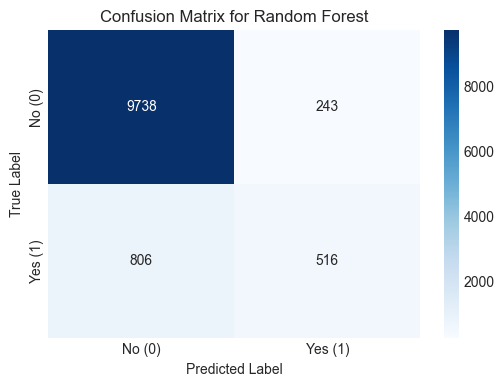


--- Training and Evaluating: Support Vector Machine (RBF Kernel) ---


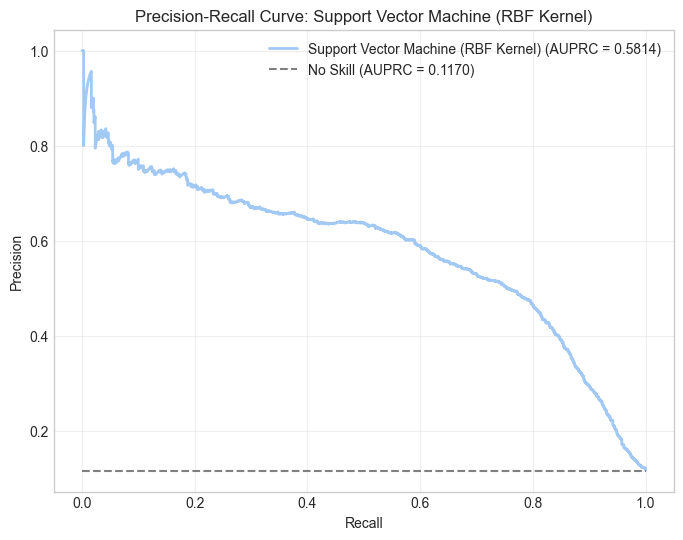

Accuracy: 0.9021
Precision: 0.6662
Recall: 0.3260
F1-score: 0.4378
G-mean: 0.5648
ROC AUC: 0.8957

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9981
           1       0.67      0.33      0.44      1322

    accuracy                           0.90     11303
   macro avg       0.79      0.65      0.69     11303
weighted avg       0.89      0.90      0.89     11303



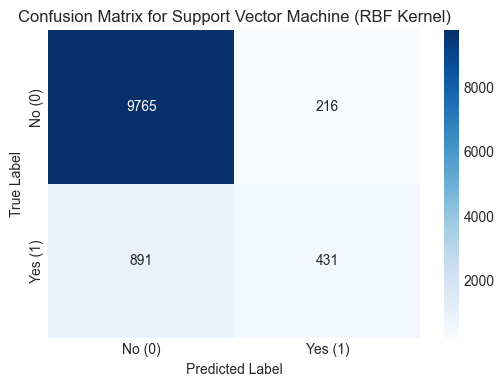


--- Training and Evaluating: Naive Bayes ---


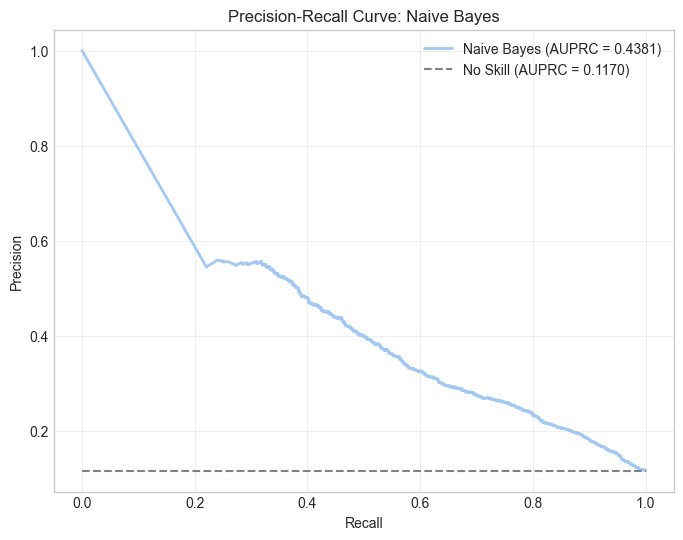

Accuracy: 0.8542
Precision: 0.4009
Recall: 0.4985
F1-score: 0.4444
G-mean: 0.6703
ROC AUC: 0.8036

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      9981
           1       0.40      0.50      0.44      1322

    accuracy                           0.85     11303
   macro avg       0.67      0.70      0.68     11303
weighted avg       0.87      0.85      0.86     11303



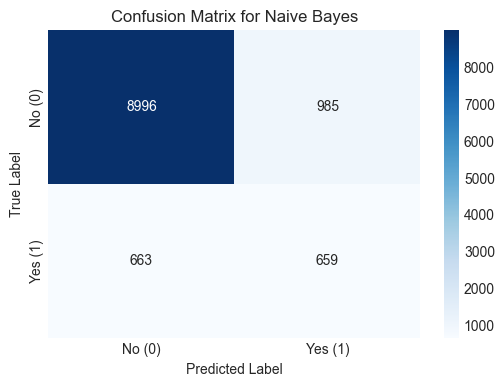


--- Training and Evaluating: LightGBM ---
[LightGBM] [Info] Number of positive: 3967, number of negative: 29941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 33908, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116993 -> initscore=-2.021219
[LightGBM] [Info] Start training from score -2.021219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

f:\venv\env\sl\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
f:\venv\env\sl\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


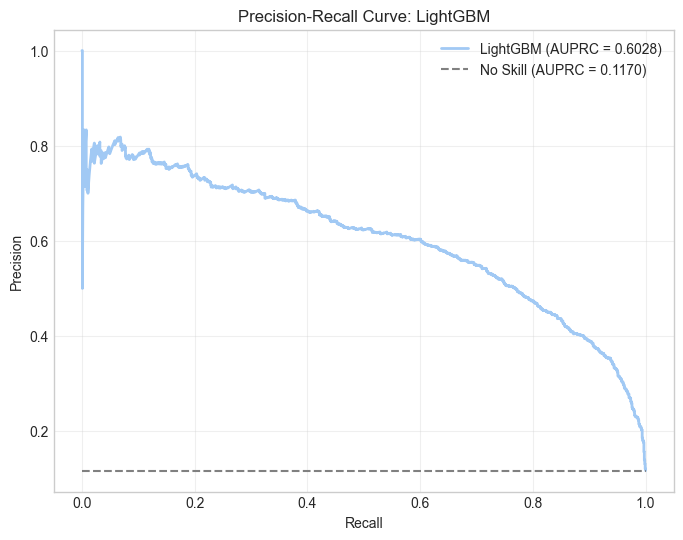

Accuracy: 0.9061
Precision: 0.6658
Recall: 0.3964
F1-score: 0.4969
G-mean: 0.6212
ROC AUC: 0.9254

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9981
           1       0.67      0.40      0.50      1322

    accuracy                           0.91     11303
   macro avg       0.79      0.69      0.72     11303
weighted avg       0.89      0.91      0.90     11303



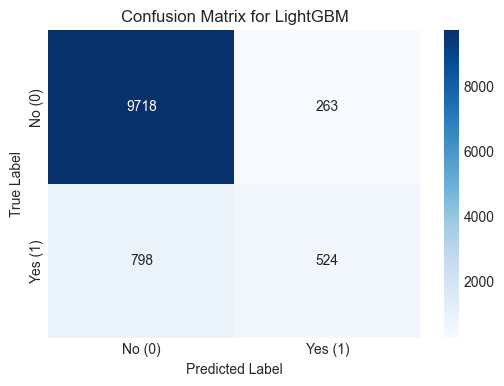


--- Training and Evaluating: CatBoost ---


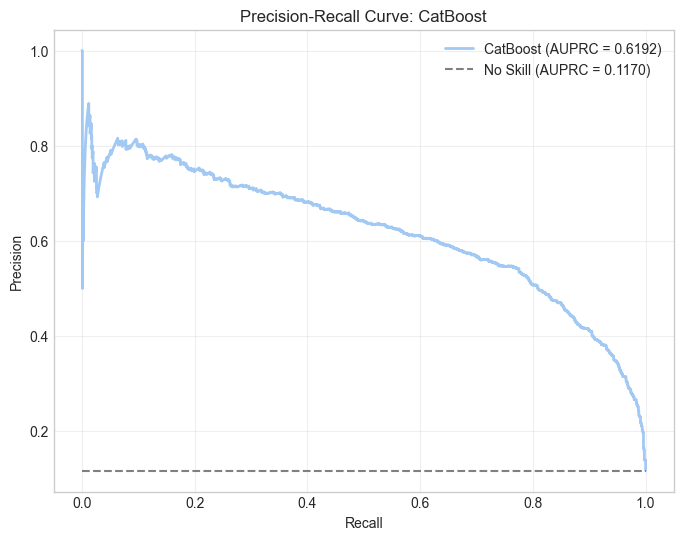

Accuracy: 0.9091
Precision: 0.6488
Recall: 0.4849
F1-score: 0.5550
G-mean: 0.6841
ROC AUC: 0.9322

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9981
           1       0.65      0.48      0.55      1322

    accuracy                           0.91     11303
   macro avg       0.79      0.73      0.75     11303
weighted avg       0.90      0.91      0.90     11303



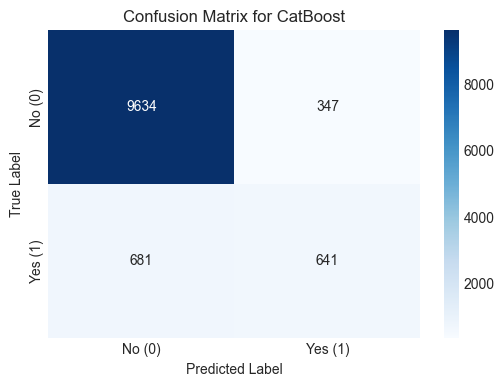


--- Training and Evaluating: XGBoost ---


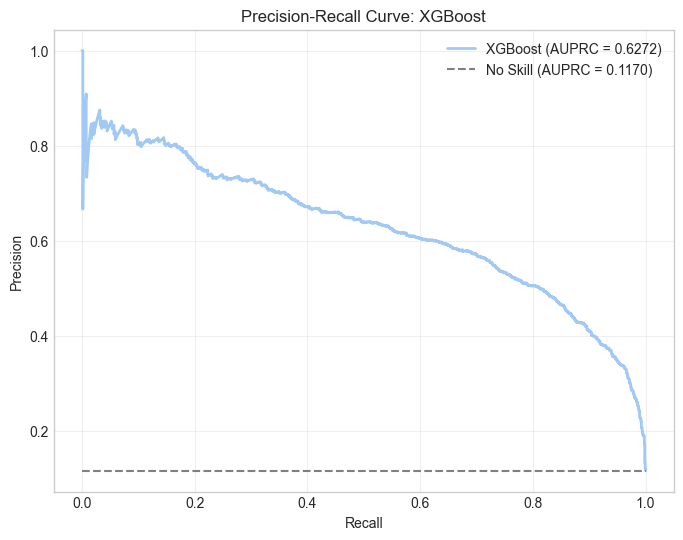

Accuracy: 0.9083
Precision: 0.6518
Recall: 0.4644
F1-score: 0.5424
G-mean: 0.6702
ROC AUC: 0.9329

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9981
           1       0.65      0.46      0.54      1322

    accuracy                           0.91     11303
   macro avg       0.79      0.72      0.75     11303
weighted avg       0.90      0.91      0.90     11303



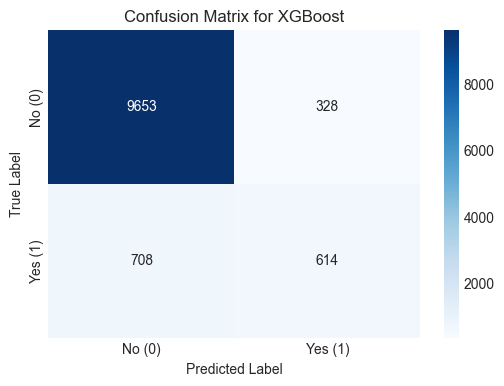

In [19]:
# 修改模型训练循环以处理CatBoost的特殊需求
for model_name, model in models.items():
    print(f"\n--- Training and Evaluating: {model_name} ---")
    
    if model_name == "CatBoost":
        # 对于CatBoost，我们直接使用原始数据并传递类别特征的索引
        pipeline = Pipeline(steps=[
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train, classifier__cat_features=categorical_indices)
    elif model_name == "LightGBM":

        # 对于LightGBM，我们可以使用预处理器
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
    elif model_name == "XGBoost":
        # 对于XGBoost，我们可以使用预处理器
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)

    elif model_name == "Naive Bayes":
        # 保持原有的Naive Bayes处理方式
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x, accept_sparse=True)),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
    else:
        # 其他模型的处理方式保持不变
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        
    # 预测和评估部分保持不变
    y_pred = pipeline.predict(X_test)
    if hasattr(pipeline, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        y_pred_proba = None
        roc_auc = np.nan

    # 评估模型
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)


    # 添加G-mean评估
    g_mean = g_mean_score(y_test, y_pred)
    
    # 添加PR曲线和AUPRC计算
    auprc = np.nan
    if y_pred_proba is not None:
        auprc = plot_pr_curve(y_test, y_pred_proba, model_name)


    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC AUC": roc_auc,
        "G-mean": g_mean,  # 添加G-mean到结果
        "AUPRC": auprc     # 添加AUPRC到结果
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"G-mean: {g_mean:.4f}")  # 打印G-mean
    if not np.isnan(roc_auc):
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("ROC AUC: Not computable for this model configuration")

    # 分类报告和混淆矩阵部分保持不变
    print("\nClassification Report:")
    classification_reports[model_name] = classification_report(y_test, y_pred, zero_division=0)
    print(classification_reports[model_name])

    plt.figure(figsize=(6, 4))
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_matrices[model_name], annot=True, fmt='d', cmap='Blues',
                xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

尝试使用torch的基本MLP进行分类

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # stratify=y 确保类别比例一致
fitted_preprocessor = preprocessor.fit(X_train)
X_train_processed = fitted_preprocessor.transform(X_train)
X_test_processed = fitted_preprocessor.transform(X_test)

In [21]:
# 检查是否是稀疏矩阵，如果是，则转换为稠密数组
if hasattr(X_train_processed, "toarray"):
    X_train_processed_dense = X_train_processed.toarray()
    X_test_processed_dense = X_test_processed.toarray()
    print("稀疏矩阵转换为稠密数组")
else:
    X_train_processed_dense = X_train_processed
    X_test_processed_dense = X_test_processed
    print("数据已经是稠密数组")

数据已经是稠密数组


In [22]:
# 获取输入特征数量
num_input_features = X_train_processed_dense.shape[1]
print(f"Number of input features for PyTorch NN: {num_input_features}")

Number of input features for PyTorch NN: 45


In [23]:
# 转换为 PyTorch Tensors
X_train_tensor = torch.tensor(X_train_processed_dense, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # BCEWithLogitsLoss需要(batch, 1)
X_test_tensor = torch.tensor(X_test_processed_dense, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [24]:
class BankDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [25]:
batch_size = 64 #可以调整
train_dataset = BankDataset(X_train_tensor, y_train_tensor)
test_dataset = BankDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [26]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128) # 增加神经元数量
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) # 添加 Dropout
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(64, 1) # 输出层为1，用于BCEWithLogitsLoss

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        
        x = self.fc3(x) # 没有sigmoid，因为BCEWithLogitsLoss会处理
        return x

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [28]:
model_nn = SimpleNN(num_input_features).to(device)
criterion_nn = nn.BCEWithLogitsLoss() # 包含Sigmoid，更稳定
optimizer_nn = optim.Adam(model_nn.parameters(), lr=0.001) # 学习率可以调整
scheduler_nn = optim.lr_scheduler.CosineAnnealingLR(optimizer_nn, T_max=50, eta_min=0)



Starting PyTorch NN training for 30 epochs...
Epoch [5/30], Train Loss: 0.2045, Test Loss: 0.2094, Test Accuracy: 0.9066, Test F1-score: 0.5393
    (This epoch is currently the best model based on F1-score: 0.5393)
Epoch [10/30], Train Loss: 0.1938, Test Loss: 0.2050, Test Accuracy: 0.9071, Test F1-score: 0.5379
Epoch [15/30], Train Loss: 0.1862, Test Loss: 0.2068, Test Accuracy: 0.9078, Test F1-score: 0.5596
Epoch [20/30], Train Loss: 0.1783, Test Loss: 0.2059, Test Accuracy: 0.9081, Test F1-score: 0.5592
Epoch [25/30], Train Loss: 0.1739, Test Loss: 0.2087, Test Accuracy: 0.9077, Test F1-score: 0.5529
Epoch [30/30], Train Loss: 0.1689, Test Loss: 0.2103, Test Accuracy: 0.9069, Test F1-score: 0.5422


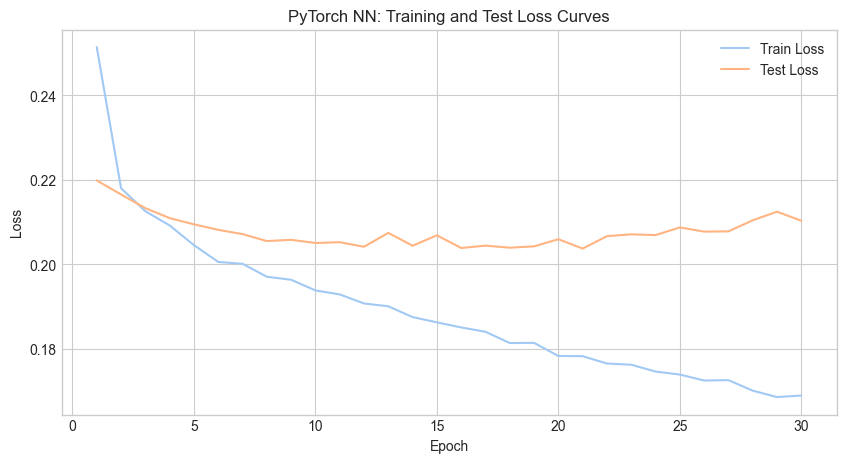

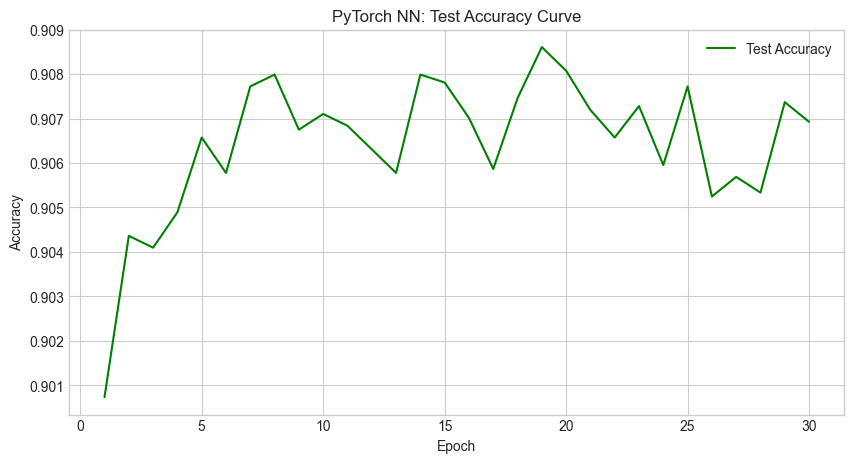

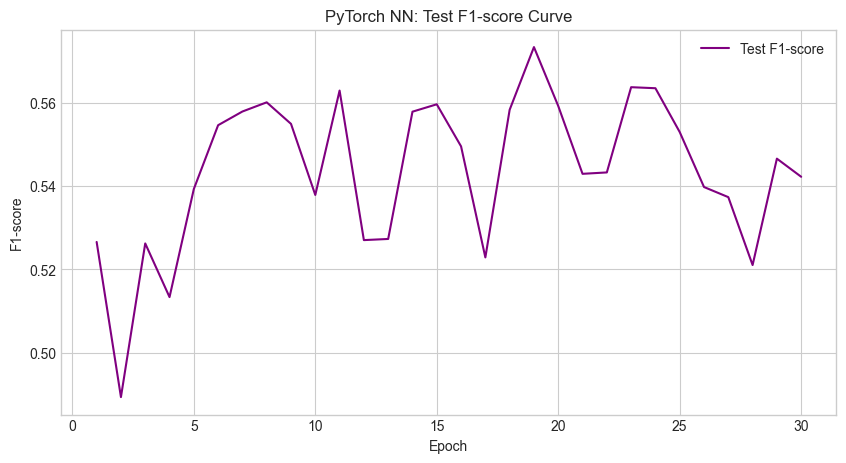

In [29]:
num_epochs = 30 # 可以调整
train_losses = [] # 记录每个epoch的训练损失
test_losses = []  # 记录每个epoch的测试损失
test_accuracies = [] # 记录每个epoch的测试准确率
test_f1_scores = []   # 记录每个epoch的测试F1-score

best_test_f1 = -1.0    # 用于追踪最佳测试F1-score
best_epoch = -1
# best_model_state_dict = None # 或者直接保存到文件

# 定义最佳模型保存路径
BEST_MODEL_PATH = 'best_model_nn.pth'

print(f"\nStarting PyTorch NN training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    model_nn.train() # 设置为训练模式
    current_train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        optimizer_nn.zero_grad()
        outputs = model_nn(data)
        loss = criterion_nn(outputs, targets)
        loss.backward()
        optimizer_nn.step()
        
        current_train_loss += loss.item() * data.size(0)

    avg_train_loss = current_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 在每个 epoch 结束后进行测试集上的评估
    model_nn.eval() # 设置为评估模式
    current_test_loss = 0.0
    
    epoch_all_targets = []
    epoch_all_predictions = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets_cpu = targets.cpu().numpy().flatten() # 先转到CPU并展平
            epoch_all_targets.extend(targets_cpu)

            targets = targets.to(device) # targets 给loss用
            
            outputs_logits = model_nn(data)
            loss = criterion_nn(outputs_logits, targets)
            current_test_loss += loss.item() * data.size(0)

            probabilities = torch.sigmoid(outputs_logits)
            predicted_cpu = (probabilities > 0.5).float().cpu().numpy().flatten() # 转到CPU并展平
            epoch_all_predictions.extend(predicted_cpu)

    avg_test_loss = current_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    
    # 计算当前epoch的测试准确率和F1-score
    # 确保 epoch_all_targets 和 epoch_all_predictions 是 numpy arrays
    np_epoch_all_targets = np.array(epoch_all_targets)
    np_epoch_all_predictions = np.array(epoch_all_predictions)

    current_test_accuracy = accuracy_score(np_epoch_all_targets, np_epoch_all_predictions)
    current_test_f1 = f1_score(np_epoch_all_targets, np_epoch_all_predictions, zero_division=0)
    
    test_accuracies.append(current_test_accuracy)
    test_f1_scores.append(current_test_f1)

    #调度器更新
    scheduler_nn.step() # 更新学习率

    # 检查是否是最佳模型 (基于F1-score)
    if current_test_f1 > best_test_f1:
        best_test_f1 = current_test_f1
        best_epoch = epoch + 1
        torch.save(model_nn.state_dict(), BEST_MODEL_PATH) # 保存最佳模型的状态字典
        # print(f"*** Epoch {epoch+1}: New best model saved with Test F1-score: {best_test_f1:.4f} ***") # 每次保存都打印

    # 每5个epoch或者最后一个epoch输出一次信息
    if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {current_test_accuracy:.4f}, Test F1-score: {current_test_f1:.4f}")
        if best_epoch == (epoch + 1): # 如果当前epoch是最佳的，也提示一下
             print(f"    (This epoch is currently the best model based on F1-score: {best_test_f1:.4f})")


# 7.5.1. 绘制训练和测试损失曲线 (保持不变)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PyTorch NN: Training and Test Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# (可选) 绘制测试准确率曲线 (保持不变)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('PyTorch NN: Test Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# 新增: 绘制测试F1-score曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_f1_scores, label='Test F1-score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('PyTorch NN: Test F1-score Curve')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# 7.6. 最终评估 PyTorch 模型 (加载在训练过程中保存的最佳模型)
print(f"\nLoading best model (from epoch {best_epoch} with Test F1-score: {best_test_f1:.4f}) for final evaluation...")
if os.path.exists(BEST_MODEL_PATH):
    model_nn.load_state_dict(torch.load(BEST_MODEL_PATH)) # 加载最佳模型的状态
else:
    print(f"Warning: Best model file '{BEST_MODEL_PATH}' not found. Evaluating the model from the last epoch.")
    # 如果没有找到最佳模型文件，将使用训练结束时的模型状态进行评估


Loading best model (from epoch 19 with Test F1-score: 0.5733) for final evaluation...


In [31]:
# 7.6. 评估 PyTorch 模型
model_nn.eval() # 设置为评估模式
all_targets_nn = []
all_predictions_nn = []
all_probabilities_nn = []

with torch.no_grad(): # 在评估时不计算梯度
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        outputs_logits = model_nn(data)
        
        # 计算概率 (通过sigmoid) 和预测类别
        probabilities = torch.sigmoid(outputs_logits)
        predicted = (probabilities > 0.5).float() #阈值为0.5

        all_targets_nn.extend(targets.cpu().numpy())
        all_predictions_nn.extend(predicted.cpu().numpy())
        all_probabilities_nn.extend(probabilities.cpu().numpy())
all_targets_nn = np.array(all_targets_nn).flatten() # 确保是一维的
all_predictions_nn = np.array(all_predictions_nn).flatten()
all_probabilities_nn = np.array(all_probabilities_nn).flatten()



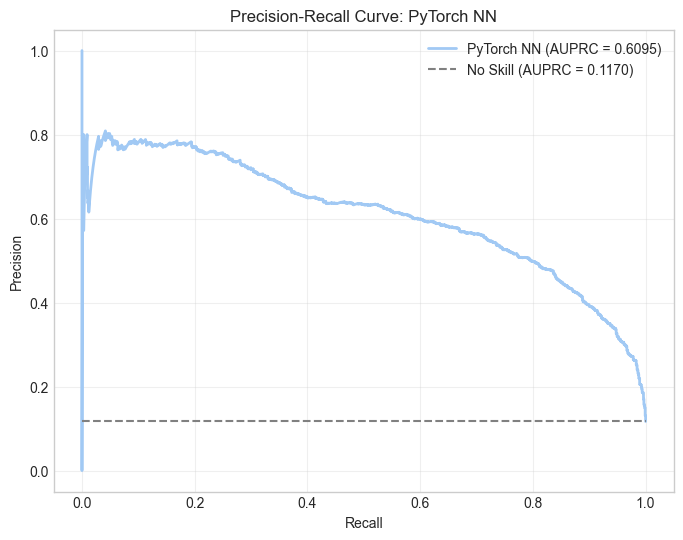

In [32]:
accuracy_nn = accuracy_score(all_targets_nn, all_predictions_nn)
precision_nn = precision_score(all_targets_nn, all_predictions_nn, zero_division=0)
recall_nn = recall_score(all_targets_nn, all_predictions_nn, zero_division=0)
f1_nn = f1_score(all_targets_nn, all_predictions_nn, zero_division=0)
roc_auc_nn = roc_auc_score(all_targets_nn, all_probabilities_nn) # 使用概率

# 添加G-mean和AUPRC计算
g_mean_nn = g_mean_score(all_targets_nn, all_predictions_nn)
auprc_nn = plot_pr_curve(all_targets_nn, all_probabilities_nn, "PyTorch NN")

In [33]:
results["PyTorch NN"] = {
    "Accuracy": accuracy_nn,
    "Precision": precision_nn,
    "Recall": recall_nn,
    "F1-score": f1_nn,
    "ROC AUC": roc_auc_nn,
     "G-mean": g_mean_nn,   # 添加G-mean
    "AUPRC": auprc_nn      # 添加AUPRC
}
print(f"\nPyTorch NN Test Metrics:")
print(f"Accuracy: {accuracy_nn:.4f}, Precision: {precision_nn:.4f}, Recall: {recall_nn:.4f}, F1-score: {f1_nn:.4f}, ROC AUC: {roc_auc_nn:.4f}")
print(f"G-mean: {g_mean_nn:.4f}, AUPRC: {auprc_nn:.4f}")  # 打印新指标


PyTorch NN Test Metrics:
Accuracy: 0.9086, Precision: 0.6315, Recall: 0.5250, F1-score: 0.5733, ROC AUC: 0.9286
G-mean: 0.7097, AUPRC: 0.6095


In [34]:
# 方法比较
results_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False) # 将结果转换为DataFrame并按ROC AUC排序
print("\n\n--- Model Comparison Summary ---") # 模型比较摘要
print(results_df)



--- Model Comparison Summary ---
                                     Accuracy  Precision    Recall  F1-score  \
XGBoost                              0.908343   0.651805  0.464448  0.542403   
CatBoost                             0.909051   0.648785  0.484871  0.554978   
PyTorch NN                           0.908608   0.631483  0.524962  0.573317   
LightGBM                             0.906131   0.665820  0.396369  0.496918   
Random Forest                        0.907193   0.679842  0.390318  0.495915   
Logistic Regression                  0.901884   0.648536  0.351740  0.456106   
Support Vector Machine (RBF Kernel)  0.902061   0.666151  0.326021  0.437786   
Naive Bayes                          0.854198   0.400852  0.498487  0.444370   
Decision Tree                        0.877024   0.474398  0.476551  0.475472   

                                      ROC AUC    G-mean     AUPRC  
XGBoost                              0.932941  0.670213  0.627231  
CatBoost                    

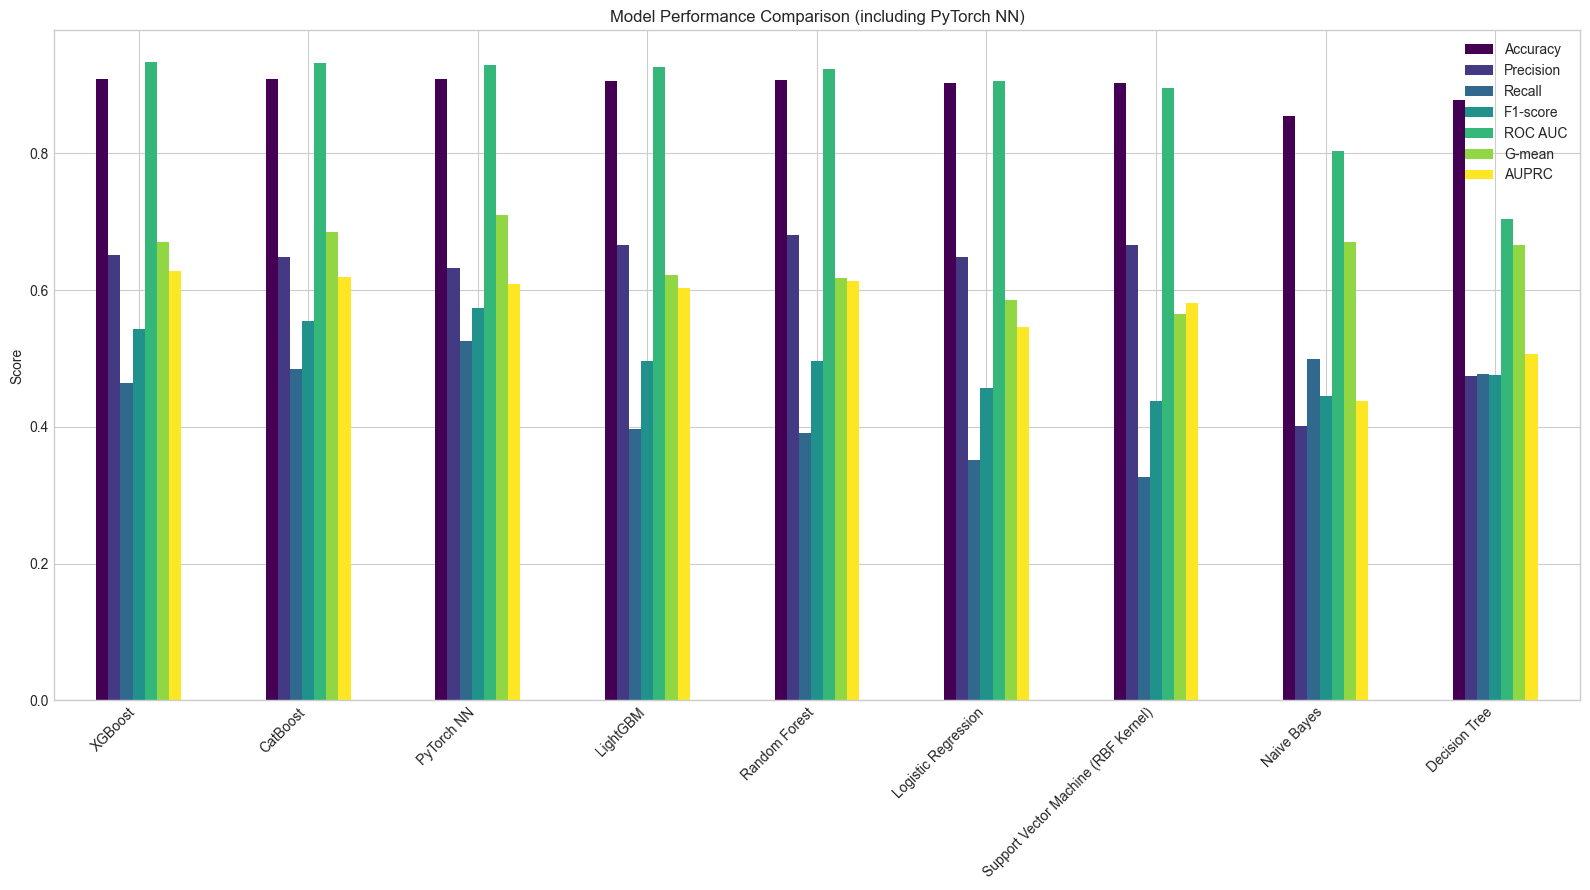

In [35]:
# 绘制结果以便于比较
results_df.plot(kind='bar', figsize=(16, 9), colormap='viridis') # 调整了图形大小
plt.title('Model Performance Comparison (including PyTorch NN)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best') # 调整legend位置
plt.tight_layout()
plt.show()


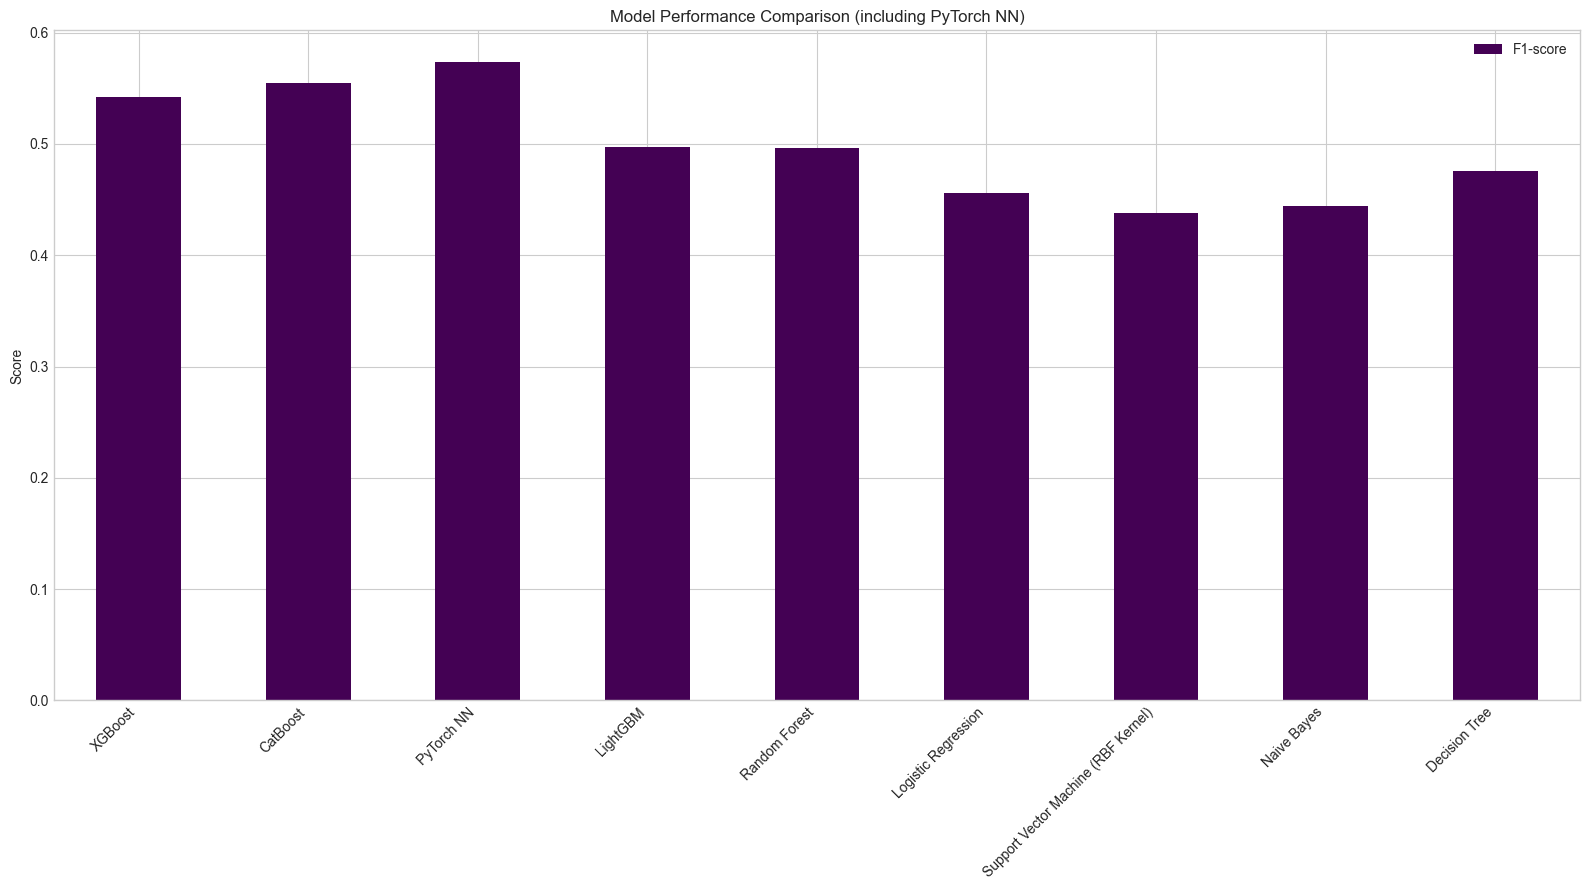

In [36]:
#只绘制F1-score列
results_df["F1-score"].plot(kind='bar', figsize=(16, 9), colormap='viridis') # 调整了图形大小
plt.title('Model Performance Comparison (including PyTorch NN)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best') # 调整legend位置
plt.tight_layout()
plt.show()

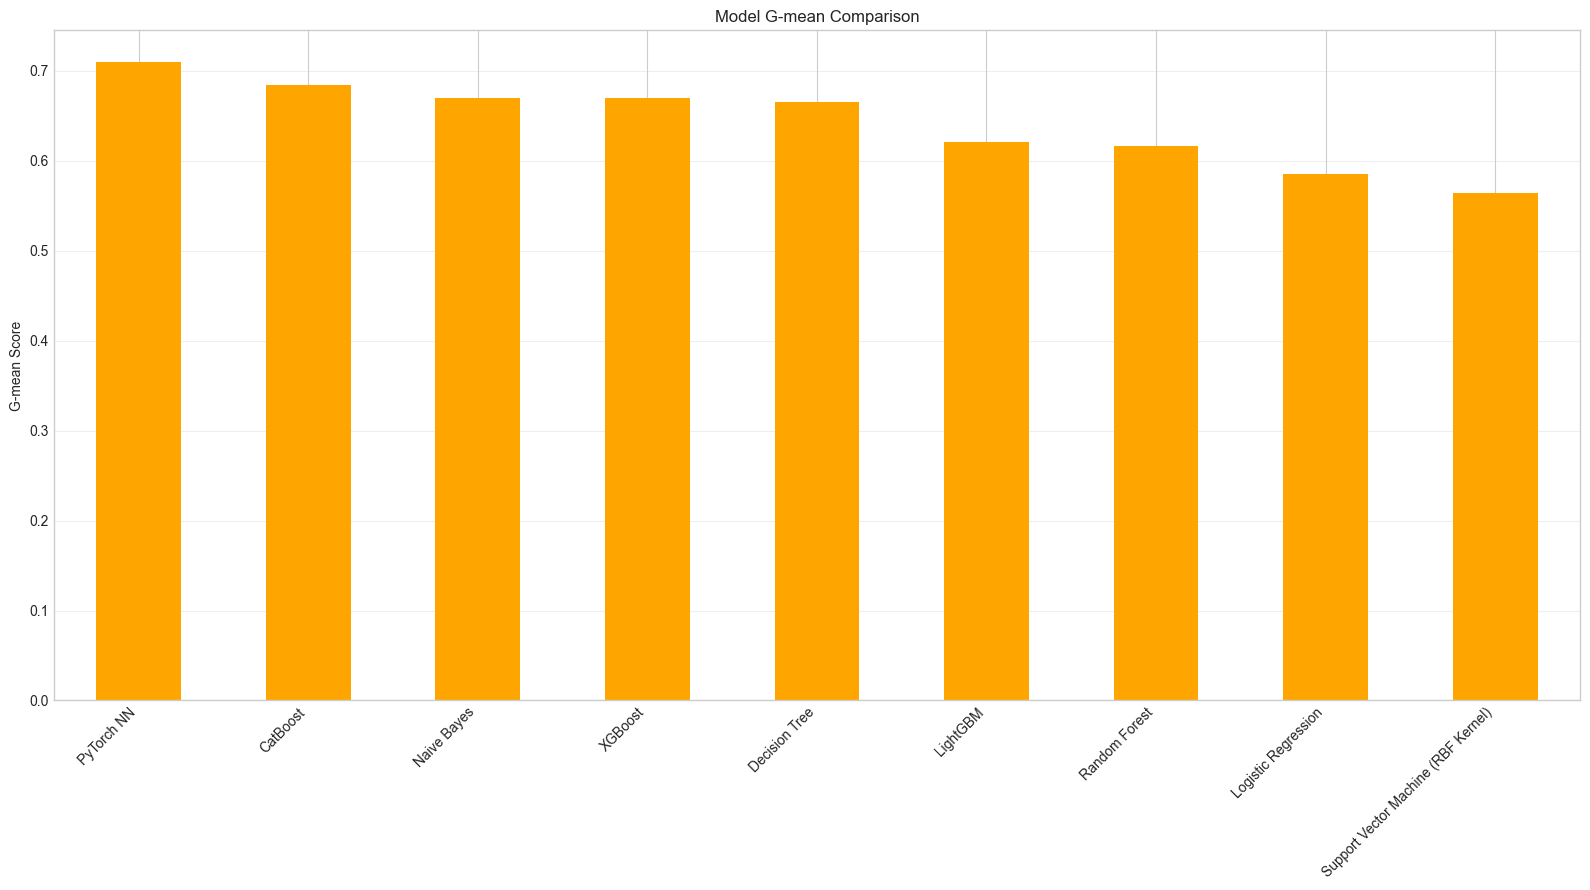

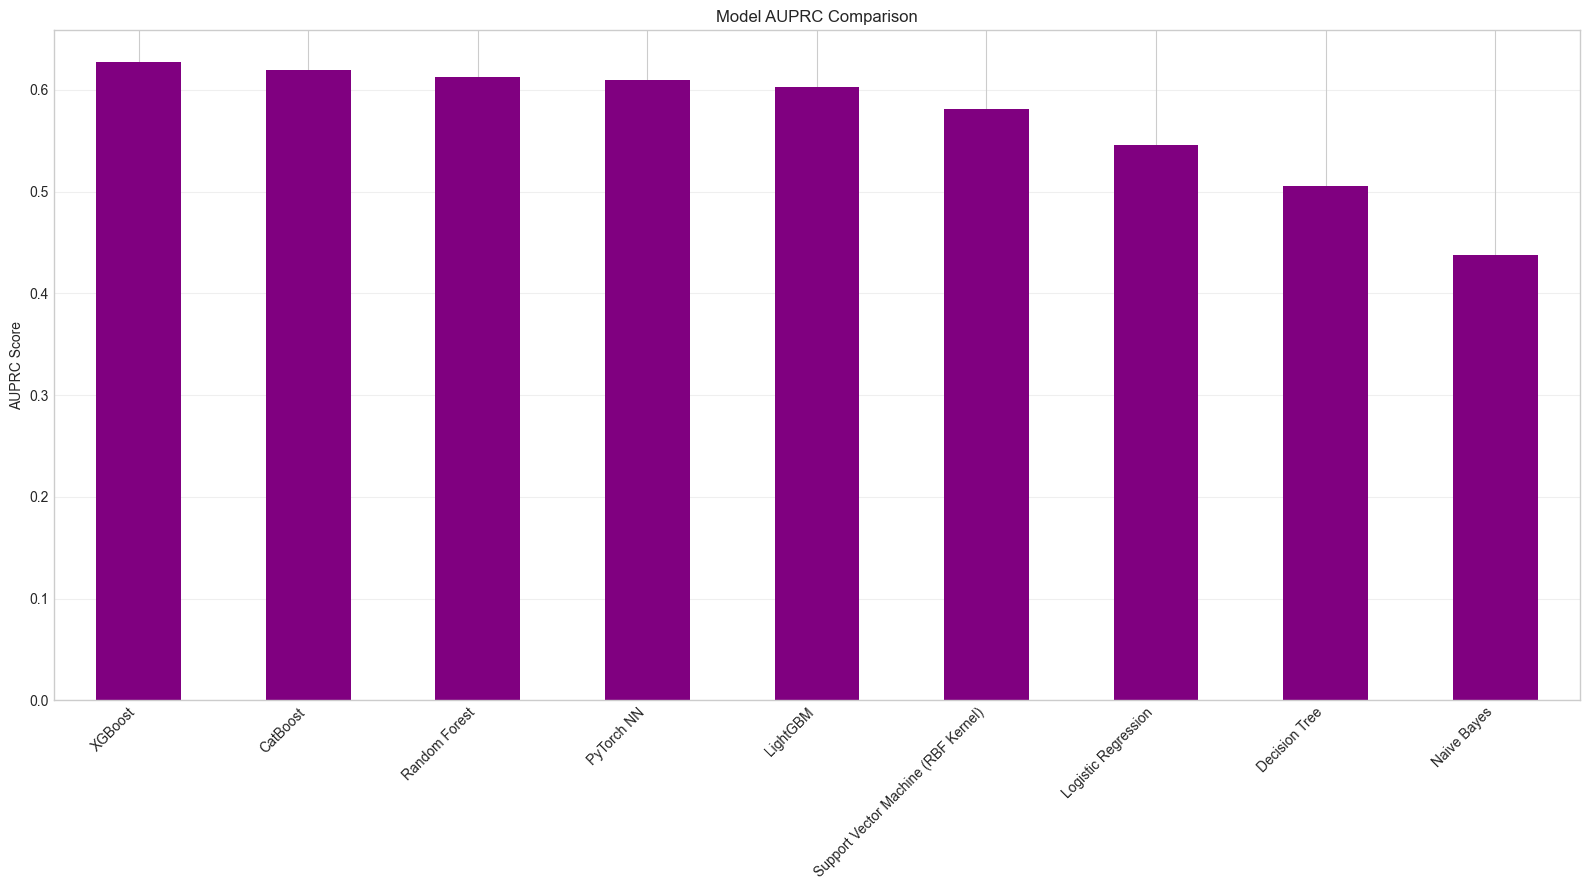

In [37]:
# 可视化G-mean指标对比
plt.figure(figsize=(16, 9))
results_df = results_df.sort_values(by="G-mean", ascending=False)
results_df["G-mean"].plot(kind='bar', figsize=(16, 9), color='orange')
plt.title('Model G-mean Comparison')
plt.ylabel('G-mean Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 可视化AUPRC指标对比
plt.figure(figsize=(16, 9))
results_df = results_df.sort_values(by="AUPRC", ascending=False)
results_df["AUPRC"].plot(kind='bar', figsize=(16, 9), color='purple')
plt.title('Model AUPRC Comparison')
plt.ylabel('AUPRC Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()